# Data Mining Workflow

## Set Up the Jupyter Notebook for Analysis

Note: We have our brand new package called swat - SAS Scripting Wrapper for Analytics Transfer - available on GitHub via pip install <br>
Copyright (c) 2017 SAS Institute Inc.

In [1]:
# Import necessary packages and modules
import swat
import pandas as pd
import collections
from matplotlib import pyplot as plt
swat.options.cas.print_messages = False
%matplotlib inline

# Define directory and data file name
indata_dir = '/viyafiles'
indata     = 'hmeq'

# Host, port, username, password
s = swat.CAS(host, port, username, password)

# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'neuralNet', 'svm', 'astore']
[s.builtins.loadactionset(i) for i in actionsets]

# Create a CAS library called DMLib pointing to the defined directory
## Note, need to specify the srctype is path, otherwise it defaults to HDFS
DMLib = s.table.addCaslib('DMlib', datasource = 'path', path = indata_dir)

# Push the relevant table In-Memory
## Note, this is a server side data load, not being loaded from the client
inMem = s.table.loadTable(indata + '.sas7bdat', casOut = indata)

# Data Exploration and Preparation

## Investigate the data - CAS

In [2]:
# Point castbl to the CAS Table object (client-side view of distributed CAS data)
castbl = s.CASTable(indata, replace = True)

# Print out the first 10 rows of the dataset
castbl.head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1.0,1700.0,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1.0,1800.0,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1.0,1800.0,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1.0,2000.0,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,1.0,2000.0,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


## Gather Summary Statistics - CAS/Python

In [3]:
# Create table of summary statistics in SAS
castbl.cardinality.summarize(cardinality = dict(name = 'data_card', replace = True))
df_data_card = s.CASTable('data_card').to_frame() # bring the data locally

# Modify SAS output table using Python to present summary statistics
df_data_card['_PCTMISS_'] = (df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100
print('\n', 'Summary Statistics'.center(90, ' '))
df_data_card[['_VARNAME_','_TYPE_','_PCTMISS_','_MIN_','_MAX_','_MEAN_','_STDDEV_','_SKEWNESS_','_KURTOSIS_']].round(2)


                                     Summary Statistics                                    


,_VARNAME_,_TYPE_,_PCTMISS_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_
0,BAD,N,0.00,0.00,1.00,0.20,0.40,1.50,0.26
1,LOAN,N,0.00,1100.00,89900.00,18607.97,11207.48,2.02,6.93
2,MORTDUE,N,8.69,2063.00,399550.00,73760.82,44457.61,1.81,6.48
3,VALUE,N,1.88,8000.00,855909.00,101776.05,57385.78,3.05,24.36
4,REASON,C,4.23,NaN,NaN,NaN,NaN,NaN,NaN
5,JOB,C,4.68,NaN,NaN,NaN,NaN,NaN,NaN
6,YOJ,N,8.64,0.00,41.00,8.92,7.57,0.99,0.37
7,DEROG,N,11.88,0.00,10.00,0.25,0.85,5.32,36.87
8,DELINQ,N,9.73,0.00,15.00,0.45,1.13,4.02,23.57
9,CLAGE,N,5.17,0.00,1168.23,179.77,85.81,1.34,7.60


## Plot Numeric Variable Distribution - CAS/Python

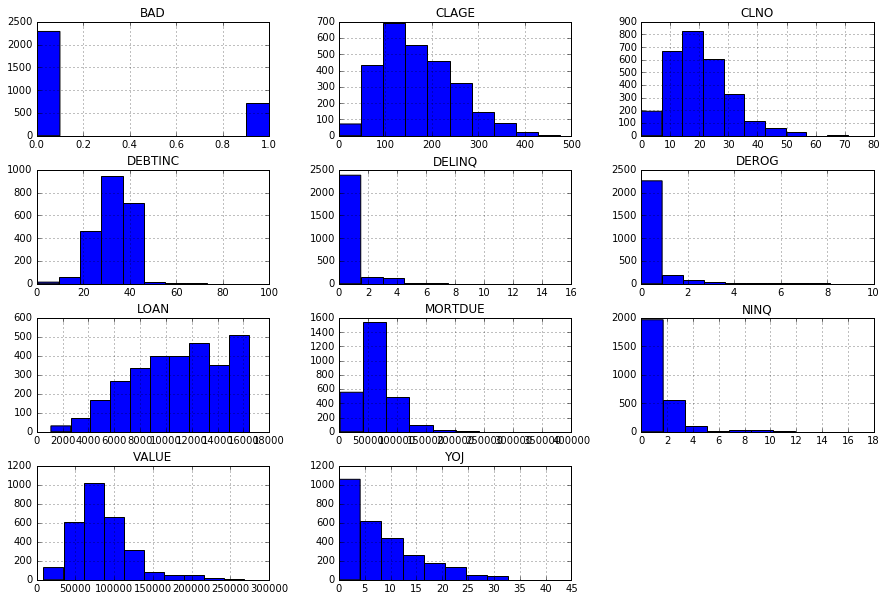

In [4]:
# Use the built in hist() method to plot the distribution of every variable
castbl.hist(figsize = (15, 10));

## Plot Missing Values - Python

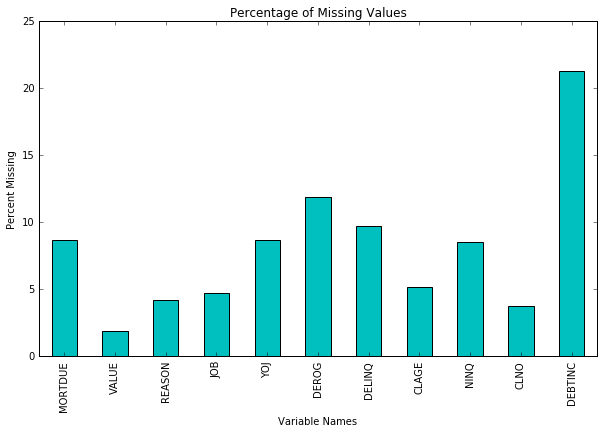

In [5]:
# Plot missing values in matplotlib
df_data_miss = df_data_card[df_data_card['_PCTMISS_'] > 0]
tbl_forplot  = pd.Series(list(df_data_miss['_PCTMISS_']), index = list(df_data_miss['_VARNAME_']))
missing_val  = tbl_forplot.plot(kind  = 'bar', title = 'Percentage of Missing Values', color = 'c', figsize = (10, 6))
missing_val.set_ylabel('Percent Missing')
missing_val.set_xlabel('Variable Names');

## Perform Imputation on Missing Values - CAS

In [6]:
# Impute missing values
castbl.dataPreprocess.impute(
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = list(df_data_card['_VARNAME_'])[1:],
    copyAllVars       = True,
    casOut            = castbl
)

# Print the first five rows with imputations
castbl.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_DEBTINC,IMP_DELINQ,IMP_DEROG,IMP_LOAN,IMP_MORTDUE,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,34.818262,0.0,0.0,1100.0,25860.0,1.0,39025.0,10.5,Other,HomeImp
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,34.818262,2.0,0.0,1300.0,70053.0,0.0,68400.0,7.0,Other,HomeImp
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,34.818262,0.0,0.0,1500.0,13500.0,1.0,16700.0,4.0,Other,HomeImp
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,...,34.818262,0.0,0.0,1500.0,65019.0,1.0,89235.5,7.0,Other,DebtCon
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,34.818262,0.0,0.0,1700.0,97800.0,0.0,112000.0,3.0,Office,HomeImp


## Partition Data into Training and Validation Sets - CAS

In [7]:
# Create a 70/30 simple random sample split
castbl.sampling.srs(
    samppct = 70,
    partind = True,
    seed    = 1,
    output  = dict(casOut = castbl, copyVars = 'ALL')
)

# Verify the partition worked properly using SQL
s.fedSQL.execDirect('''
    SELECT 
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END AS Name,
        _PartInd_,
        100.0*COUNT(*)/(SELECT COUNT(*) FROM ''' + indata + ''') AS Pct
    FROM ''' + indata + '''
    GROUP BY
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END,
        _PartInd_
    ORDER BY _PartInd_ DESC;
''')

,NAME,_PartInd_,PCT
0,Training,1.0,70.0
1,Validation,0.0,30.0


# Build Models

## Set Modeling Shortcuts - Python

### Models to be performed

In [8]:
# Models to be performed
models = collections.OrderedDict()
models['dt']  = 'Decision Tree'
models['gbt'] = 'Gradient Boosting'
models['nn']  = 'Neural Network'
models['svm'] = 'Support Vector Machine'

### Set variable shortcuts

In [9]:
# Set variables for later use by models
## For models that can handle missing values
target              = df_data_card['_VARNAME_'][0]
class_inputs        = list(df_data_card.query('_TYPE_ == "C"')['_VARNAME_'])
interval_inputs     = list(df_data_card.query('_TYPE_ == "N"')['_VARNAME_'])[1:]
class_vars          = [target] + class_inputs
all_inputs          = interval_inputs + class_inputs

## For models that can't handle missing values
imp_class_inputs    = ['IMP_' + s for s in class_inputs]
imp_interval_inputs = ['IMP_' + s for s in interval_inputs]
imp_class_vars      = [target] + imp_class_inputs
imp_all_inputs      = imp_interval_inputs + imp_class_inputs

### Set modeling argument shortcuts (**kwargs)

In [10]:
# Set key-word argument shortcuts (common model inputs)
## For models that can handle missing values (decision tree, gradient boosting)
params = dict(
    table    = dict(name = indata, where = '_partind_ = 1'), 
    target   = target, 
    inputs   = all_inputs, 
    nominals = class_vars,
)

## For models that can't have missing values (neural network, support vector machine)
imp_params = dict(
    table    = dict(name = indata, where = '_partind_ = 1'), 
    target   = target, 
    inputs   = imp_all_inputs, 
    nominals = imp_class_vars,
)

## Decision Tree - CAS

In [11]:
s.decisionTree.dtreeTrain(**params, varImp = True, casOut = dict(name = 'dt_model', replace = True))

,Descr,Value
0,Number of Tree Nodes,15.000000
1,Max Number of Branches,2.000000
2,Number of Levels,6.000000
3,Number of Leaves,8.000000
4,Number of Bins,20.000000
5,Minimum Size of Leaves,5.000000
6,Maximum Size of Leaves,3197.000000
7,Number of Variables,12.000000
8,Confidence Level for Pruning,0.250000
9,Number of Observations Used,4172.000000


## Gradient Boosting - CAS

In [12]:
s.decisionTree.gbtreeTrain(**params, seed = 1, casOut = dict(name = 'gbt_model', replace = True))

,Descr,Value
0,Number of Trees,50.0
1,Distribution,2.0
2,Learning Rate,0.1
3,Subsampling Rate,0.5
4,Number of Selected Variables (M),12.0
5,Number of Bins,20.0
6,Number of Variables,12.0
7,Max Number of Tree Nodes,61.0
8,Min Number of Tree Nodes,19.0
9,Max Number of Branches,2.0


## Neural Network - CAS

In [13]:
s.neuralNet.annTrain(**imp_params, seed = 1, casOut = dict(name = 'nn_model', replace = True))

,Progress,Objective,Loss
0,1.0,5.470003,5.470003
1,2.0,3.101988,3.101988
2,3.0,1.618312,1.618312
3,4.0,1.580249,1.580249
4,5.0,1.545793,1.545793
5,6.0,1.538129,1.538129
6,7.0,1.532759,1.532759
7,8.0,1.529136,1.529136
8,9.0,1.527706,1.527706
9,10.0,1.527508,1.527508


## Support Vector Machine - CAS

In [14]:
s.svm.svmTrain(**imp_params, seed = 1, kernel = 'polynomial', id = [target, '_partind_'], savestate = 'svm_model')

,Descr,Value
0,Task Type,C_CLAS
1,Optimization Technique,Interior Point
2,Scale,YES
3,Kernel Function,Polynomial
4,Kernel Degree,2
5,Penalty Method,C
6,Penalty Parameter,1
7,Maximum Iterations,25
8,Tolerance,1e-06
,Descr,N


# Model Comparison

## Score the Models on Validation Data - CAS/Python

In [15]:
def score_model(model):
    score = dict(
        table      = indata,
        modelTable = model + '_model',
        copyVars   = [target, '_partind_'],
        casOut     = dict(name = '_scored_' + model, replace = True)
    )
    return score

### Decision Tree
s.decisionTree.dtreeScore(**score_model('dt'))

### Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))

### Neural Network
s.neuralNet.annScore(**score_model('nn'))

### Support Vector Machine
castbl.astore.score(rstore = 'svm_model', out = dict(name = '_scored_svm', replace = True))

### Create standardized prediction column
for i in range(len(models)-1):
    s.dataStep.runCode('''
        data _scored_''' + list(models)[i] + '''; 
            set _scored_''' + list(models)[i] + ''';
            if _''' + list(models)[i] + '''_predname_ = 1
                then p_''' + target + '''1 = _''' + list(models)[i] + '''_predp_; 
                else p_''' + target + '''1 = 1 - _''' + list(models)[i] + '''_predp_;
        run;
    ''')

## Assess the Performance - CAS/Python

In [16]:
# Model assessment function
def assess_model(model):
    assess = s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_partind_ = 0'),
        inputs   = 'p_' + target + '1',      
        response = target,
        event    = '1',   
    )
    return assess

# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model'] = list(models.values())[i]
    roc_df = pd.concat([roc_df, tmp.ROCInfo])

# Display stacked confusion matrix using Python
print('\n', 'Confusion Matrix Information'.center(42, ' '))
roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'TP', 'FP', 'FN', 'TN']].reset_index(drop = True)


        Confusion Matrix Information       


,Model,TP,FP,FN,TN
0,Decision Tree,253.0,145.0,113.0,1277.0
1,Gradient Boosting,241.0,55.0,125.0,1367.0
2,Neural Network,116.0,63.0,250.0,1359.0
3,Support Vector Machine,97.0,20.0,269.0,1402.0


## Compare Misclassification Rates - Python

In [17]:
# Add misclassification rate calculation
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


,Model,Misclassification
1,Gradient Boosting,0.100671
0,Decision Tree,0.144295
3,Support Vector Machine,0.161633
2,Neural Network,0.175056


## Create ROC Curve - Python

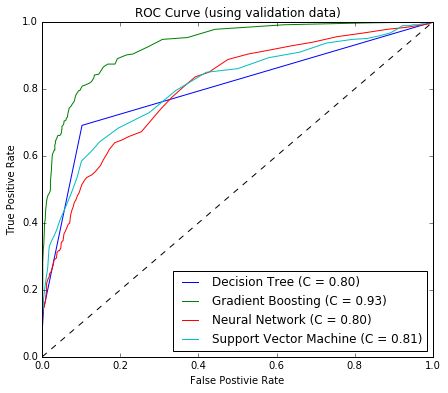

In [18]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)');

## Compare Scikit-Learn Gradient Boosting - Python

In [19]:
# Bring specified columns to the client (note: Python models must be run locally)
local_inputs = [target, '_PartInd_'] + imp_all_inputs
local = castbl[local_inputs].to_frame()

# Create dummy variables for class inputs (note: scikit-learn cannot have character variables)
local = pd.concat([local, pd.get_dummies(local[imp_class_inputs])], axis = 1).drop(imp_class_inputs, axis = 1)

# Split into training and validation
train = local[local['_PartInd_'] == 1]
valid = local[local['_PartInd_'] == 0]

# Split target and inputs and remove unnecessary variables (note: scikit-learn Gradient Boosting can't handle missing values)
X_train = train.drop(target, axis = 1)
X_valid = valid.drop(target, axis = 1)
y_train = train[target]
y_valid = valid[target]

# Build scikit-learn gradient boosting model using default values
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
df = pd.DataFrame(dict(actual = y_valid, pred = gb.predict_proba(X_valid)[:,1])) # put results in pandas dataframe

# Predict and assess model
gb_y_score           = gb.predict(X_valid)
gb_misclassification = 1 - accuracy_score(y_valid, gb_y_score)
gb_confusion_matrix  = confusion_matrix(y_valid, gb_y_score)

print('Confusion Matrix\n', gb_confusion_matrix, '\n') # note: scikit-learn reverses True Positives and True Negatives
print('Misclassification Rate\n ', gb_misclassification)

Confusion Matrix
 [[1379   43]
 [ 145  221]] 

Misclassification Rate
  0.10514541387


## Add Python model results to CAS to assess - CAS/Python

In [20]:
pytbl = s.upload_frame(df, casout=dict(name='Python', replace=True))

# Verify that the Python actuals vs. predicted are in CAS
pytbl.fetch(to = 5)

,actual,pred
0,1.0,0.897448
1,1.0,0.862536
2,1.0,0.751502
3,1.0,0.704959
4,1.0,0.933171


## Compare Misclassification & ROC Curves - CAS/Python

In [21]:
# Assess the Python model using CAS
python_assess = pytbl.percentile.assess(
    inputs   = 'pred',      
    response = 'actual',
    event    = '1',   
)
python_assess.ROCInfo['Model'] = 'Gradient Boosting - Python'
roc_df['Model'] = roc_df['Model'] + ' - CAS'
roc_df = pd.concat([roc_df.query('Model == "Gradient Boosting - CAS"'), python_assess.ROCInfo])
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


,Model,Misclassification
0,Gradient Boosting - CAS,0.100671
1,Gradient Boosting - Python,0.105145


# Save the CAS Gradient Boosting Model

In [22]:
# Generate the model code that can be leveraged by CAS in the future
unload = s.table.save('gbt_model', name = 'gbt_model', replace = True)

In [23]:
s.session.endsession() # end the session

+ Elapsed: 0.00417s, user: 0.001s, sys: 0.003s, mem: 0.113mb